## HDMI Input
### use base.bit
HDMI入力をJupyterで使えるようにする。

---

In [1]:
from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *
import numpy as np
import time
import PIL.Image

In [2]:
# base = BaseOverlay("base.bit")
# XLNK = base.ps7_0
# print(XLNK)
# XLNK.xlnk_reset()

In [3]:
from base_mod2 import BaseOverlay
## base = BaseOverlay("base.bit")
base = BaseOverlay("/home/xilinx/pynq/overlays/my_design/base_wrapper.bit")
XLNK = base.ps7_0
print(XLNK)
XLNK.xlnk_reset()

In [4]:
hdmi_in = base.video.hdmi_in
hdmi_in.configure(PIXEL_RGB)
hdmi_in.cacheable_frames = False
hdmi_in.start()

In [5]:
frame = hdmi_in.readframe()
frame.shape

# NG Type
# TMP-1 0x44810
# TMP-2 0x44810

# OK Type
# TMP-1 0x35810
# TMP-4 0x35810

(720, 1280, 3)

In [6]:
## そのままPillowに渡すとJupyter KernelがPanicするので
## 確保済みNumpy配列にコピー。
buf = np.ndarray(frame.shape, dtype=np.uint8)
XLNK.cma_memcopy(buf, frame, np.prod(frame.shape))

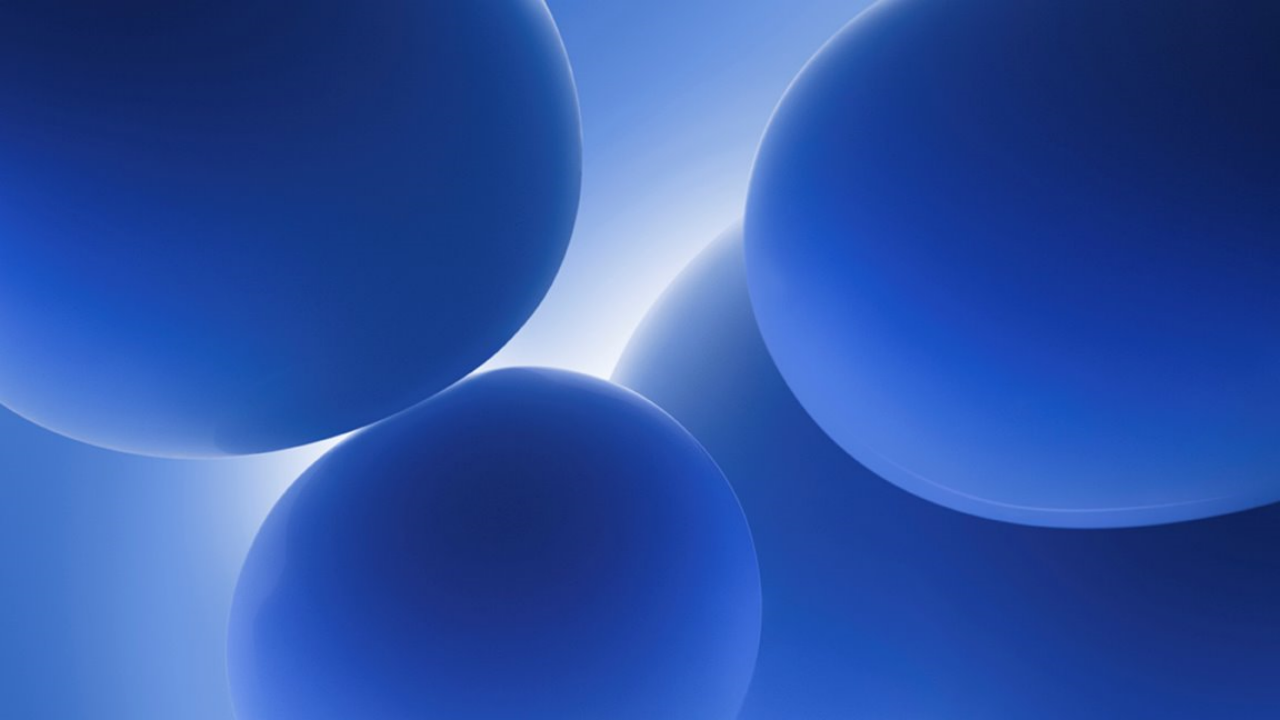

In [7]:
image = PIL.Image.fromarray(buf)
image

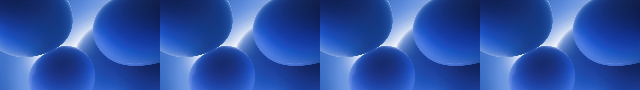

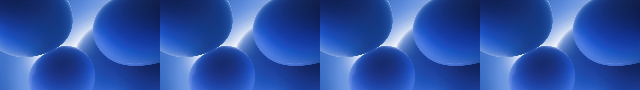

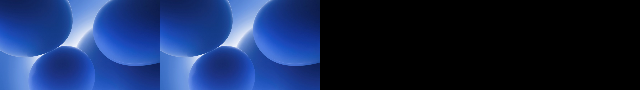

1.20s, 8.36fps


In [8]:
N = 10
M = 4

buf = np.ndarray(frame.shape, dtype=np.uint8)
start = time.time()

for n in range(N):
    frame = hdmi_in.readframe()
    XLNK.cma_memcopy(buf, frame, np.prod(frame.shape))
    
    image = PIL.Image.fromarray(buf)
    image = image.resize([s//8 for s in image.size]) ## Resize
    
    if n%M==0:
        concat = PIL.Image.new('RGB', (image.width*M, image.height))
        concat.paste(image, (image.width*(n%M), 0))
    elif n%M==M-1 or n==N-1:
        concat.paste(image, (image.width*(n%M), 0))
        display(concat)
    else:
        concat.paste(image, (image.width*(n%M), 0))

    frame.freebuffer()
    
    base.leds.write(1<<(n%4), 0xF)

elasp = time.time() - start
print(f"{elasp:.2f}s, {N/elasp:.2f}fps")

In [ ]:
frame.freebuffer()

In [ ]:
hdmi_in.close()